In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import seaborn as sns

In [2]:
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Preprocess

In [7]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [8]:
features['CPI'].fillna(features['CPI'].median(),inplace=True)
features['Unemployment'].fillna(features['Unemployment'].median(),inplace=True)
features['TotalMarkDown'] = features['MarkDown1'] +features['MarkDown2'] +features['MarkDown3'] +features['MarkDown4'] + features['MarkDown5']
features.drop(['MarkDown1' , 'MarkDown2' , 'MarkDown3' , 'MarkDown4' , 'MarkDown5'], inplace= True ,  axis = 1)
features.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,TotalMarkDown
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True,NaN
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False,NaN
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False,NaN
4,1,2010-03-05,46.50,2.625,211.350143,8.106,False,NaN


In [9]:
df = features.merge(stores , on = 'Store' , how = 'inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          8190 non-null   int64  
 1   Date           8190 non-null   object 
 2   Temperature    8190 non-null   float64
 3   Fuel_Price     8190 non-null   float64
 4   CPI            8190 non-null   float64
 5   Unemployment   8190 non-null   float64
 6   IsHoliday      8190 non-null   bool   
 7   TotalMarkDown  2520 non-null   float64
 8   Type           8190 non-null   object 
 9   Size           8190 non-null   int64  
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 584.0+ KB


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [11]:
df = df.merge(train , on = ['Store' , 'Date'] , how = 'inner')
test = test.merge(stores , on = 'Store' , how = 'inner')

In [12]:
df = df.loc[df['Weekly_Sales'] > 0]

In [13]:
df_prophet = df.copy()

In [14]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [15]:
num_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','TotalMarkDown']
df = normalization(df,num_col)
df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,TotalMarkDown,Type,Size,Dept,Weekly_Sales,IsHoliday_y
0,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,A,0.630267,1,0.035961,False
1,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,A,0.630267,2,0.073013,False
2,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,A,0.630267,3,0.019824,False
3,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,A,0.630267,4,0.057645,False
4,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,A,0.630267,5,0.046500,False


EDA

In [16]:
means = {}
columns_to_plot = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig = make_subplots(rows=2, cols=2, subplot_titles=columns_to_plot)
def plotday(col , row_num , col_num ):
    
    means[col] = df.groupby('Date')[col].mean().reset_index()
    fig.add_trace(go.Scatter(x=means[col]['Date'], y=means[col][col], mode='lines', name=col) , row = row_num , col =col_num)
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Value')
    fig.update_layout(title_text='Average Over Time', showlegend=False)
    fig.update_layout(height=800, width=1000, template='plotly_dark')


In [17]:

for i , col in enumerate(columns_to_plot):
    plotday(col, row_num = i//2+1 , col_num = i%2+1)
fig.show()

In [18]:
means = {}
columns_to_plot = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig1 = make_subplots(rows=2, cols=2, subplot_titles=columns_to_plot)
def plotstore(col , row_num , col_num ):
    mean_data = df.groupby('Store')[col].mean().reset_index()
    bar_chart = px.bar(mean_data, x='Store', y=col)
    

    for trace in bar_chart.data:
        fig1.add_trace(go.Bar(x=trace.x, y=trace.y, name=trace.name), row=row_num, col=col_num)

    fig1.update_xaxes(title_text='Store')
    fig1.update_yaxes(title_text='Value')
    fig1.update_layout(title_text='Average by Store', showlegend=False)
    fig1.update_layout(height=800, width=1000, template='plotly_dark')


In [19]:
for i , col in enumerate(columns_to_plot):
    plotstore(col, row_num = i//2+1 , col_num = i%2+1)
fig1.show()

In [20]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].mean().reset_index()

fig = px.line(weekly_sales, x='Date', y='Weekly_Sales', title='Avg Weekly Sales over Time')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Weekly Sales')

fig.update_layout(height=600, width=1000, template='plotly_dark')

fig.show()

In [21]:
store_mean_weekly_sales = train.groupby('Store')['Weekly_Sales'].mean().reset_index()

fig = px.bar(store_mean_weekly_sales, x='Store', y='Weekly_Sales', title='Average Weekly Sales by Store')

fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Average Weekly Sales')

fig.update_layout(template='plotly_dark')

fig.show()

In [22]:
dept_mean_weekly_sales = train.groupby('Dept')['Weekly_Sales'].mean().reset_index()

fig = px.bar(dept_mean_weekly_sales, x='Dept', y='Weekly_Sales', title='Average Weekly Sales by Dept')

fig.update_xaxes(title_text='Dept')
fig.update_yaxes(title_text='Average Weekly Sales')

fig.update_layout(template='plotly_dark')

fig.show()

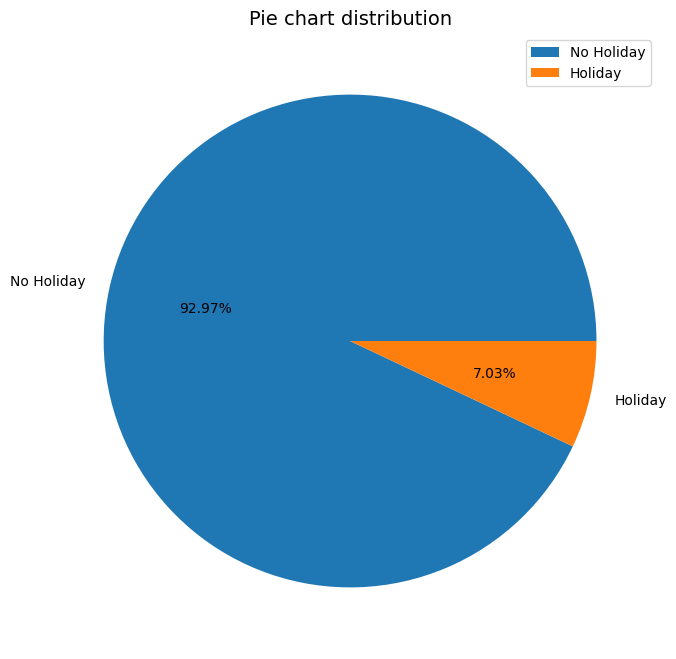

In [23]:
plt.figure(figsize=(8,8))
plt.pie(df['IsHoliday_x'].value_counts(),labels=['No Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=14)
plt.legend()
plt.show() 

In [24]:
df_cor = df.copy()
type_group = {'A':1, 'B': 2, 'C': 3} 
df_cor['Type'] = df_cor['Type'].replace(type_group)
df_cor.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,TotalMarkDown,Type,Size,Dept,Weekly_Sales,IsHoliday_y
0,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,1,0.630267,1,0.035961,False
1,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,1,0.630267,2,0.073013,False
2,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,1,0.630267,3,0.019824,False
3,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,1,0.630267,4,0.057645,False
4,1,2010-02-05,0.434149,0.0501,0.8405,0.405118,False,NaN,1,0.630267,5,0.046500,False


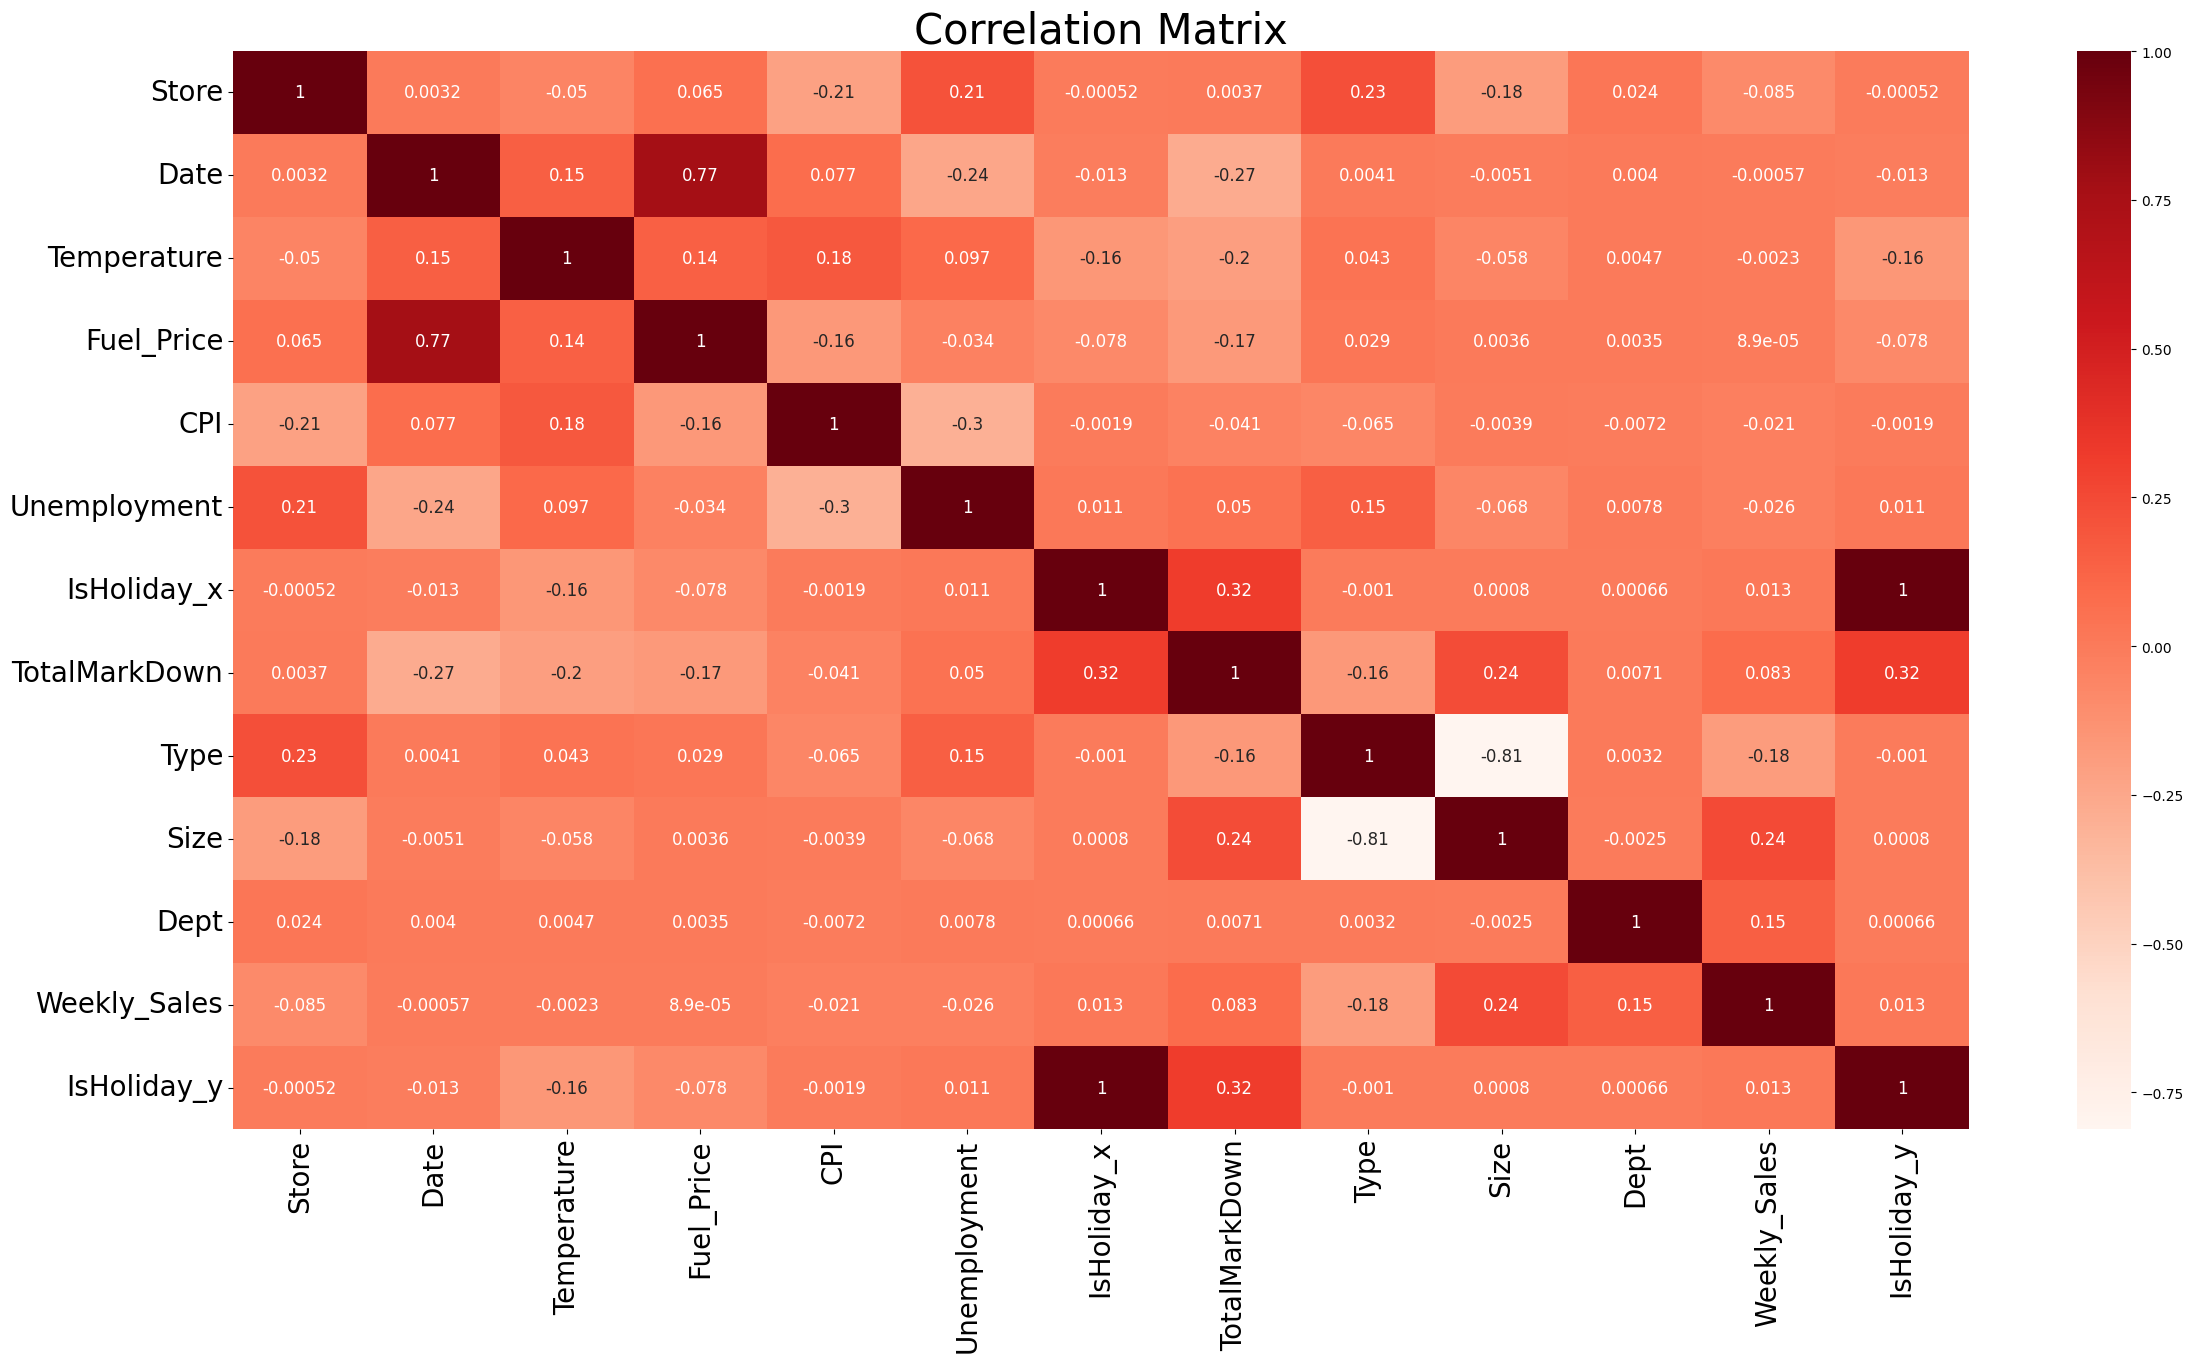

In [25]:
plt.figure(figsize=(28,14))
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

sns.heatmap(df_cor.corr(), cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix', fontsize=30);

In [26]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date', inplace=True, axis=1)
df= pd.get_dummies(df, columns=['Store', 'Dept', 'Type'])
df['IsHoliday_x'].replace({True:1, False:0}, inplace=True)
df['IsHoliday_y'].replace({True:1, False:0}, inplace=True)
df['TotalMarkDown'].fillna(0,inplace=True)



In [27]:
df.head()

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,TotalMarkDown,Size,Weekly_Sales,IsHoliday_y,Month,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,0.434149,0.0501,0.8405,0.405118,0,0.0,0.630267,0.035961,0,2,...,False,False,False,False,False,False,False,True,False,False
1,0.434149,0.0501,0.8405,0.405118,0,0.0,0.630267,0.073013,0,2,...,False,False,False,False,False,False,False,True,False,False
2,0.434149,0.0501,0.8405,0.405118,0,0.0,0.630267,0.019824,0,2,...,False,False,False,False,False,False,False,True,False,False
3,0.434149,0.0501,0.8405,0.405118,0,0.0,0.630267,0.057645,0,2,...,False,False,False,False,False,False,False,True,False,False
4,0.434149,0.0501,0.8405,0.405118,0,0.0,0.630267,0.046500,0,2,...,False,False,False,False,False,False,False,True,False,False


In [28]:
target_column = 'Weekly_Sales'

X = df.drop(target_column, axis=1)
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (378190, 139)
X_test shape: (42022, 139)
y_train shape: (378190,)
y_test shape: (42022,)


Linear Regression model

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [30]:
linear_regression_accuracy = lr.score(X_test,y_test)*100
print("Linear Regressor Accuracy - ",linear_regression_accuracy)


Linear Regressor Accuracy -  66.04162335095435


In [31]:
y_pred = lr.predict(X_test)

print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.011785955397832325
MSE 0.00036999695353413396
RMSE 0.01923530487239893
R2 0.6604170754555396


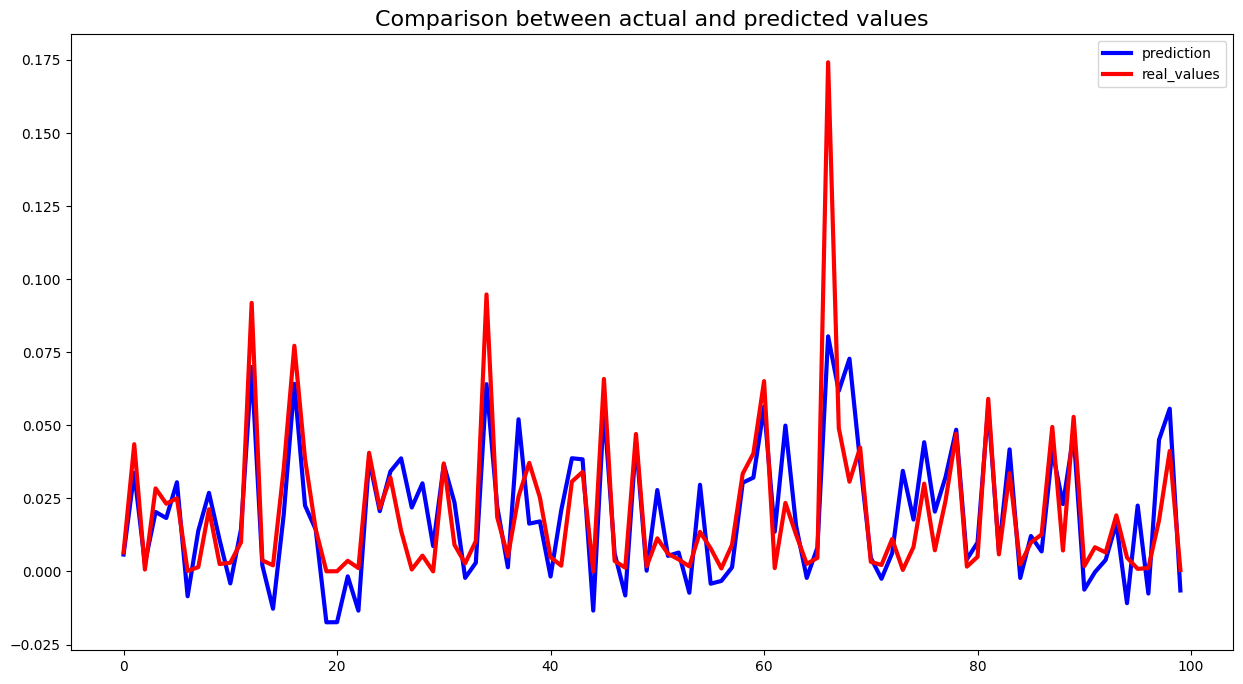

In [32]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(lr.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
plt.show()

Random Forest model

In [33]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
random_forest_accuracy = rf.score(X_test,y_test)*100
print("Random Forest Regressor Accuracy - ",random_forest_accuracy)

Random Forest Regressor Accuracy -  97.1824367835469


In [35]:
y_pred = rf.predict(X_test)

print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.0022679896716942846
MSE 3.069904716740286e-05
RMSE 0.005540672086254777
R2 0.9718251994092668


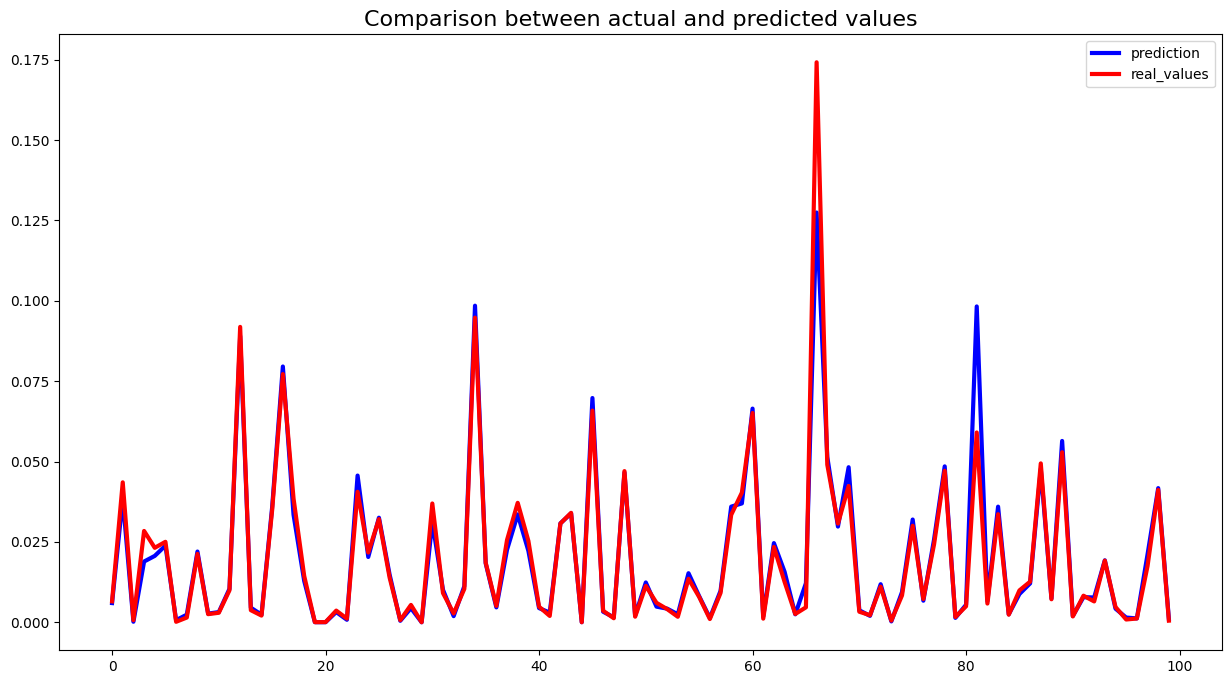

In [36]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(rf.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
plt.show()

Kneigbours model

In [37]:
knn = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=1)

In [38]:
knn_accuracy = knn.score(X_test, y_test)*100
print("KNeigbhbors Regressor Accuracy - ",knn_accuracy)

KNeigbhbors Regressor Accuracy -  91.39132650848674


In [39]:
y_pred = knn.predict(X_test)

print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.0031120633200704246
MSE 9.37966793509688e-05
RMSE 0.009684868576855795
R2 0.913913989824046


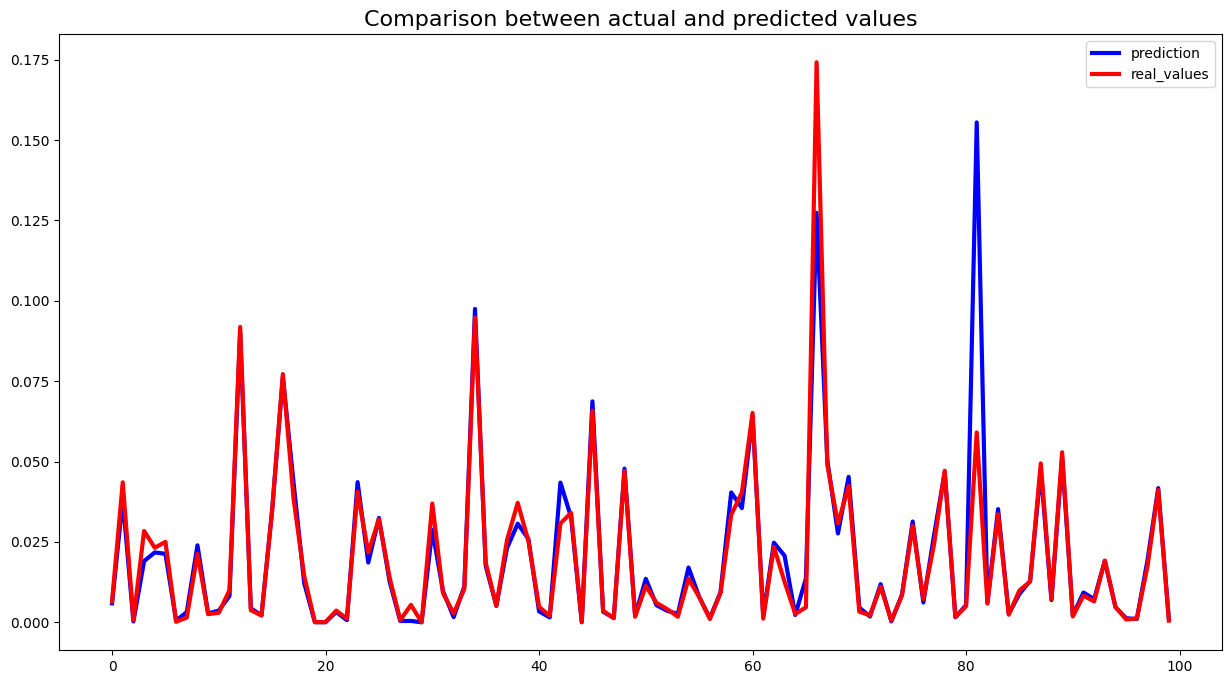

In [40]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(knn.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
#plt.savefig('knn_real_pred.png')
plt.show()

Prophet

In [41]:
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [42]:
df_prophet

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,TotalMarkDown,Type,Size,Dept,Weekly_Sales,IsHoliday_y
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN,A,151315,1,24924.50,False
1,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN,A,151315,2,50605.27,False
2,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN,A,151315,3,13740.12,False
3,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN,A,151315,4,39954.04,False
4,1,2010-02-05,42.31,2.572,211.096358,8.106,False,NaN,A,151315,5,32229.38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,58.85,3.882,192.308899,8.667,False,5247.26,B,118221,93,2487.80,False
421566,45,2012-10-26,58.85,3.882,192.308899,8.667,False,5247.26,B,118221,94,5203.31,False
421567,45,2012-10-26,58.85,3.882,192.308899,8.667,False,5247.26,B,118221,95,56017.47,False
421568,45,2012-10-26,58.85,3.882,192.308899,8.667,False,5247.26,B,118221,97,6817.48,False


In [43]:
store_num = 1
Dept_num = 1
store = df_prophet[(df_prophet['Store'] == store_num) & (df_prophet['Dept'] == Dept_num)]
store = store[['Date','Weekly_Sales']]

store['Date'] = pd.to_datetime(store['Date']) #converting 'date' column to a datetime type
store.columns=['ds','y'] #Rename columns
store

,ds,y
0,2010-02-05,24924.50
73,2010-02-12,46039.49
145,2010-02-19,41595.55
218,2010-02-26,19403.54
290,2010-03-05,21827.90
...,...,...
9883,2012-09-28,18947.81
9956,2012-10-05,21904.47
10028,2012-10-12,22764.01
10101,2012-10-19,24185.27


In [44]:
testcol = len(store)-20
y_train = store.iloc[:testcol]
y_test = store.iloc[testcol:]

In [45]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(y_train)

02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:13 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
future = model.make_future_dataframe(periods=52, freq='W-Fri') 
forecast = model.predict(future)
fig=plot_plotly(model, forecast)
py.iplot(fig)

In [47]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', "trend"]]

,ds,yhat,yhat_lower,yhat_upper,trend
0,2010-02-05,32279.148555,24240.417730,39981.803489,24675.228630
1,2010-02-12,38342.671990,30922.238941,45959.145147,24669.577427
2,2010-02-19,37069.837637,29680.791577,44616.976928,24663.926223
3,2010-02-26,29105.340388,20955.310360,36721.073561,24658.275020
4,2010-03-05,20023.561656,12175.653824,28276.669356,24652.623817
...,...,...,...,...,...
170,2013-05-10,18217.450918,10500.276287,25975.653208,23825.387194
171,2013-05-17,16471.358870,8510.527119,24476.824959,23820.437657
172,2013-05-24,15343.308041,7603.488529,23197.854203,23815.488121
173,2013-05-31,15429.634525,7395.935859,22424.350867,23810.538584


In [48]:
plot_components_plotly(model, forecast)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18860\2606071378.py:5: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "bx:" (-> color='b'). The keyword argument will take precedence.

C:\Users\Admin\AppData\Local\Temp\ipykernel_18860\2606071378.py:6: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.



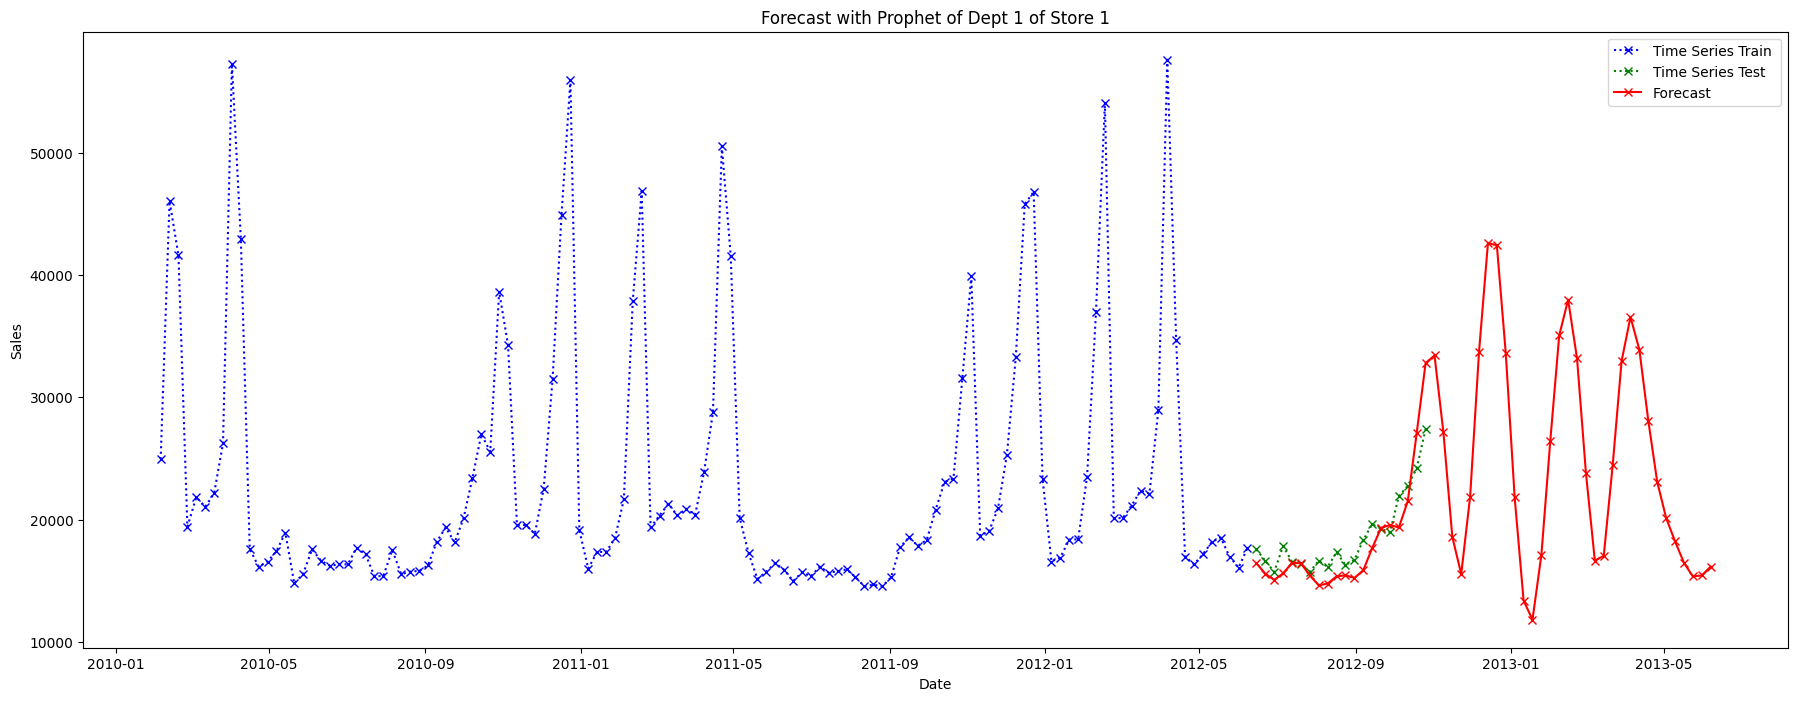

In [49]:
plt.figure(figsize=(22,8))

plt.plot(y_train['ds'], y_train['y'], 'bx:')

plt.plot(y_test['ds'], y_test['y'], 'bx:', color='green')
plt.plot(forecast["ds"][testcol:], forecast["yhat"][testcol:], "bx-", color="red")

plt.legend(['Time Series Train ','Time Series Test','Forecast'])
title1 = "Forecast with Prophet of Dept " + str(Dept_num) + ' of Store ' + str(store_num)
plt.title(title1)
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

In [50]:
y_pred = forecast['yhat'][testcol:].head(len(y_test)).values

In [51]:
print("MAE" , metrics.mean_absolute_error(y_test['y'].values, y_pred))
print("MSE" , metrics.mean_squared_error(y_test['y'].values, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test['y'].values, y_pred)))
print("R2" , metrics.explained_variance_score(y_test['y'], y_pred))

MAE 1519.9680443707502
MSE 3817320.6430461025
RMSE 1953.7964691968564
R2 0.6391565196910276
